In [18]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
# REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH,DEVICE)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8653.54it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8214.91it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data_loader import DataLoaderInit
input_dim = 512
output_dim = 512
batch_size = 500

autoencoder = SimpleAutoencoder(input_dim,output_dim)
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVis_pre_autoencoder_res/loss_contrastive.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [3]:
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CLEAN_PATH,REF_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_b_features,tar_b_features = BoundaryGen.get_boundary_features(DEVICE,num_adv_eg=1000)

NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8185.48it/s]


NET resnet18_with_dropout
Finish initialization...


 80%|███████▉  | 199/250 [00:01<00:00, 132.42it/s]


KeyboardInterrupt: 

In [3]:
ref_border_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
tar_border_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)

NameError: name 'ref_b_features' is not defined

In [15]:
from AlignVis.utils import *
val = []
num = 0
for i in range(len(ref_border_pred)):
    mes_val = EMAE(ref_border_pred[i], tar_border_pred[i])
    if mes_val < 15:
        num = num + 1

    val.append(mes_val)
print(num)
               

555


In [13]:
r_pred_Res = ref_border_pred.argmax(axis=1)
t_pred_Res = tar_border_pred.argmax(axis=1)

In [14]:
num = 0
for i in range(len(ref_border_pred)):
    
    if r_pred_Res[i] == t_pred_Res[i]:
        num = num + 1
print(num)

320


In [10]:
val

[12.928565084934235,
 20.262319874763488,
 8.153565990924836,
 9.784021306037904,
 16.856829822063446,
 17.152423644065856,
 15.831669998168945,
 21.021121299266817,
 10.209069776535035,
 20.90023763179779,
 13.002718389034271,
 9.420758306980133,
 8.036670458316802,
 26.914295983314513,
 8.295363926887513,
 16.968048167228698,
 17.22612918615341,
 11.822639191150666,
 17.42124695777893,
 23.393104243278504,
 8.586724114418029,
 15.022493040561676,
 14.948931336402893,
 15.139168977737427,
 13.514120233058929,
 13.530410504341125,
 17.20862352848053,
 17.84858627319336,
 17.393691694736482,
 11.41704249382019,
 9.65851445198059,
 13.98818427324295,
 20.63348505496979,
 20.45627965927124,
 20.571435427665712,
 9.733658325672149,
 11.266233348846436,
 12.491637945175171,
 13.198001384735107,
 11.816570007801056,
 10.899599480628968,
 17.169894111156463,
 11.835388481616974,
 11.38019210100174,
 22.275094819068908,
 11.065380024909974,
 10.963410186767579,
 10.387447488307952,
 15.6309811

In [4]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, CLEAN_PATH, CLEAN_PATH, 200,200, projector, DEVICE)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8017.98it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8208.74it/s]


In [6]:
new2_encoder_border,ref_features,tar_features = AutoEncoder_Generator.encoder_active_learning_only_border("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVis_pre_autoencoder_res/loss_contrastive.pth", saved_path="/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVis_pre_autoencoder_res/new__acb.pth",num_epochs=5)

NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8219.23it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 132.44it/s]


data1_index or data2_index is None
conf1 (218, 10) (4, 10) (218, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (1853, 10) (3, 10) (1853, 10)
conf1 (218, 10) (8, 10) (218, 10) (8, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (218, 10) (8, 10) (218, 10) (8, 10)
data1_index or data2_index is None
conf1 (218, 10) (1853, 10) (218, 10) (1853, 10)
conf1 (108, 10) (8, 10) (108, 10) (8, 10)
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
data1_index or data2_index is None
conf1 (218, 10) (3, 10) (218, 10) (3, 10)
conf1 (108, 10) (1853, 10) (108, 10) (1853, 10)
data1_index or data2_index is None
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_in

100%|██████████| 25/25 [00:00<00:00, 13296.68it/s]


all boundary 451 aligned 833
(833, 512)
current aligned number: 833 total aligned number: 833


100%|██████████| 5/5 [00:00<00:00, 7584.64it/s]


epoch0, pred loss:13.478643417358398,loss_f_decoder:0.0003936855646315962,loss_f_encoder:0.0007533772150054574 


100%|██████████| 250/250 [00:01<00:00, 127.83it/s]


data1_index or data2_index is None
conf1 (218, 10) (4, 10) (218, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
data1_index or data2_index is None
conf1 (218, 10) (3, 10) (218, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (1853, 10) (8, 10) (1853, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (108, 10) (3, 10) (108, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (1853, 10) (8, 10) (1853, 10)
conf1 (108, 10) (8, 10) (108, 10) (8, 10)
conf1 (8, 10) (4, 10) (8, 10) (

100%|██████████| 25/25 [00:00<00:00, 13181.35it/s]


all boundary 472 aligned 816
(816, 512)
current aligned number: 816 total aligned number: 1649


100%|██████████| 5/5 [00:00<00:00, 9606.74it/s]


epoch1, pred loss:13.303594589233398,loss_f_decoder:0.0003940271562896669,loss_f_encoder:0.0007592716719955206 


100%|██████████| 250/250 [00:01<00:00, 127.21it/s]


data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (108, 10) (8, 10) (108, 10) (8, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (1853, 10) (3, 10) (1853, 10)
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (218, 10) (1853, 10) (218, 10) (1853, 10)
conf1 (8, 10) (4, 10) (8, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (3, 10) (4, 10) (3, 10) (4, 10)
conf1 (218, 10) (3, 10) (218, 10) (3, 10)
data1_index or data2_index is None
conf1 (108, 10) (218, 10) (108, 10) (218, 10)
data1_index or data2_index is None
data1_index or data2_

100%|██████████| 25/25 [00:00<00:00, 13543.99it/s]


all boundary 448 aligned 817
(817, 512)
current aligned number: 817 total aligned number: 2466


100%|██████████| 5/5 [00:00<00:00, 8587.85it/s]


epoch2, pred loss:12.003938674926758,loss_f_decoder:0.000390026398235932,loss_f_encoder:0.0007676606765016913 


100%|██████████| 250/250 [00:01<00:00, 126.98it/s]


conf1 (3, 10) (1853, 10) (3, 10) (1853, 10)
conf1 (108, 10) (8, 10) (108, 10) (8, 10)
conf1 (108, 10) (218, 10) (108, 10) (218, 10)
data1_index or data2_index is None
conf1 (108, 10) (3, 10) (108, 10) (3, 10)
conf1 (8, 10) (4, 10) (8, 10) (4, 10)
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
data1_index or data2_index is None
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (218, 10) (3, 10) (218, 10) (3, 10)
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
data1_index or data2_index is None
conf1 (3, 10) (4, 10) (3, 10) (4, 10)
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
conf1 (8, 10) (3, 10) (8, 10) (3, 10)
conf1 (218, 10) (1853, 10) (218, 10) (1853, 10)
data1_index or data2_ind

100%|██████████| 25/25 [00:00<00:00, 13310.18it/s]


all boundary 421 aligned 841
(841, 512)
current aligned number: 841 total aligned number: 3307


100%|██████████| 5/5 [00:00<00:00, 8626.71it/s]


epoch3, pred loss:11.795665740966797,loss_f_decoder:0.00038124830462038517,loss_f_encoder:0.0007505458779633045 


100%|██████████| 250/250 [00:01<00:00, 127.14it/s]


data1_index or data2_index is None
data1_index or data2_index is None
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
conf1 (218, 10) (1853, 10) (218, 10) (1853, 10)
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
data1_index or data2_index is None
conf1 (108, 10) (1853, 10) (108, 10) (1853, 10)
conf1 (218, 10) (8, 10) (218, 10) (8, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (8, 10) (1853, 10) (8, 10) (1853, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index or data2_index is None
conf1 (218, 10) (4, 10) (218, 10) (4, 10)
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
conf1 (108, 10) (1853, 10) (108, 10) (1853, 10)
conf1 (8, 10) (1853, 10) (8, 10) (1853, 10)
conf1 (4, 10) (1853, 10) (4, 10) (1853, 10)
conf1 (3, 10) (4, 10) (3, 10) (4, 10)
data1_index or data2_index is None
conf1 (108, 10) (4, 10) (108, 10) (4, 10)
data1_index or data2_index is None
data1_index or data2_index is None
data1_index 

100%|██████████| 25/25 [00:00<00:00, 13158.19it/s]


all boundary 476 aligned 781
(781, 512)
current aligned number: 781 total aligned number: 4088


100%|██████████| 4/4 [00:00<00:00, 8008.22it/s]

epoch4, pred loss:11.405043601989746,loss_f_decoder:0.00039284591912291944,loss_f_encoder:0.0007802057079970837 


In [8]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
        sim = []
        sim_l = []
        target_preserving = []
        ref_preserving = []
        for i in range(len(ref_border)):
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] == tar_border[i]:
                sim.append(i)
            if ref_border_l[i] == tar_border_l[i] and tar_border_l[i] == tar_border[i]:
                sim_l.append(i)
            if tar_border_l[i] == tar_border[i]:
                 target_preserving.append(i)
            if ref_border_l[i] == ref_border[i]:
                 ref_preserving.append(i)


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("target keep same boundary sample preserving{}/{}".format(len(sim_l),len(sim)))
        print("target keep boundary and non boundary{}/{}".format(len(target_preserving),len(tar_b_features)))
        print("target keep boundary and non boundary{}/{}".format(len(ref_preserving),len(ref_b_features)))
        

In [7]:
len(ref_features)

4410

In [10]:
eval_boundary_align_sensitivity(autoencoder, tar_features, ref_features)

123


100%|██████████| 21/21 [00:00<00:00, 13301.18it/s]


388


100%|██████████| 21/21 [00:00<00:00, 11827.63it/s]

boundary sample preserving312/388
target keep same boundary sample preserving1174/1784
target keep boundary and non boundary2480/4088
target keep boundary and non boundary3086/4088


In [9]:
eval_boundary_align_sensitivity(new2_encoder_border, tar_features, ref_features)

123


100%|██████████| 21/21 [00:00<00:00, 12949.19it/s]


388


100%|██████████| 21/21 [00:00<00:00, 11029.35it/s]

boundary sample preserving214/388
target keep same boundary sample preserving1144/1784
target keep boundary and non boundary2130/4088
target keep boundary and non boundary3086/4088


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8213.75it/s]


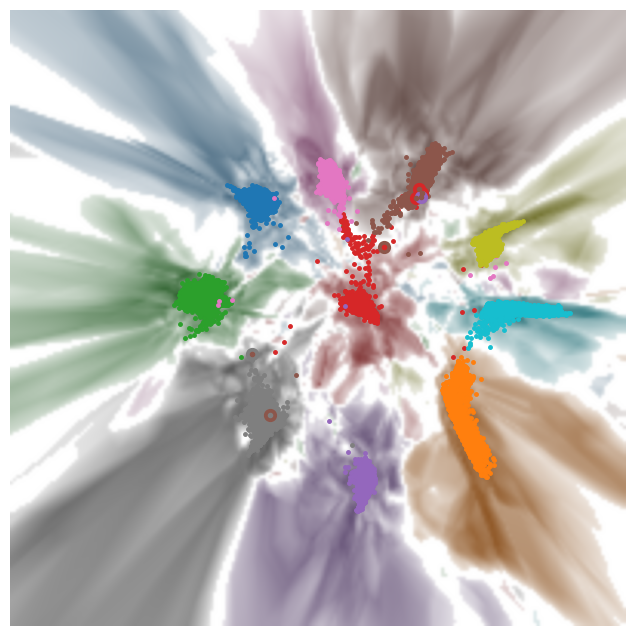

In [27]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8154.67it/s]


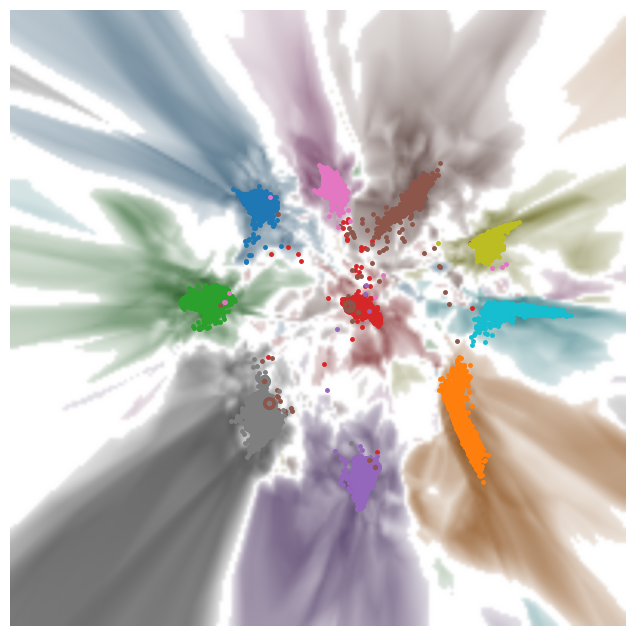

In [17]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis2'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = new2_encoder_border.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, new2_encoder_border, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/img2.png"))

Computing decision regions ...


100%|██████████| 25/25 [00:00<00:00, 12569.84it/s]


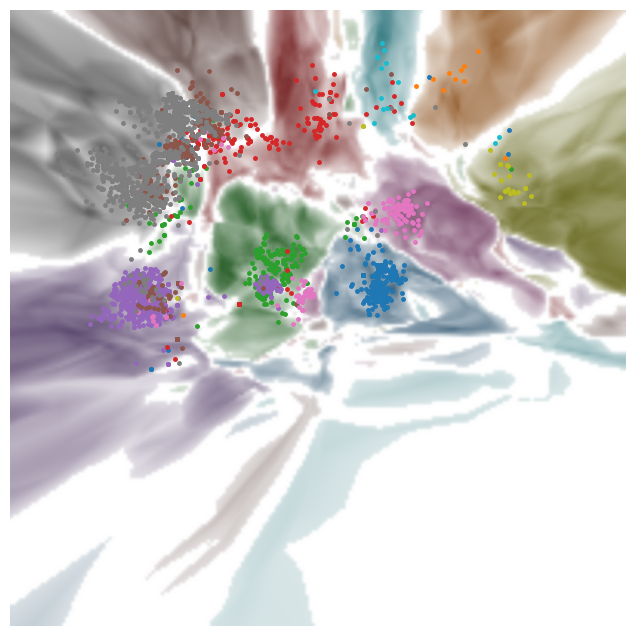

In [32]:
import os
VIS_MODEL_NAME = 'vis'
encoded_Y_B = autoencoder.encoder(torch.Tensor(tar_features))
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from AlignVis_Visualizer.visualizer_boundary import visualizer
vis = visualizer(ref_provider, ref_features, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [15]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 8760.84it/s]


long distance move subet number is 3181, short distance move set number is 489


100%|██████████| 250/250 [00:00<00:00, 8203.79it/s]


all reference distance preserving 49919/50000
all target distance preserving 49998/50000
short distance move direction preserving 487/489
long distance move direction preserving 3177/3181


In [14]:
eval.eval_move_direction_preserving(new2_encoder_border,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 8779.62it/s]


long distance move subet number is 3181, short distance move set number is 489


100%|██████████| 250/250 [00:00<00:00, 8203.41it/s]


all reference distance preserving 49919/50000
all target distance preserving 49996/50000
short distance move direction preserving 487/489
long distance move direction preserving 3177/3181


In [11]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8115.91it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:49898/50000 1.00
ref&tar pred_same preserving:49050/49988 0.98
ref&tar pred_diff preserving:12/12 1.00


In [17]:
val_same, val_diff = eval.eval_prediction_preserving(new2_encoder_border)

100%|██████████| 250/250 [00:00<00:00, 8028.85it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:49914/50000 1.00
ref&tar pred_same preserving:49065/49988 0.98
ref&tar pred_diff preserving:12/12 1.00


In [13]:
eval.eval_boundary_nn_ref_in_ref(ref_features)

#train# boundary preserving: 2.30/15 in epoch 200


2.29986

In [12]:
eval.eval_boundary_nn_autoencoder(tar_features,autoencoder)

#train# boundary preserving: 0.00/15 in epoch 200


0.00418

In [14]:
from singleVis.eval.evaluate import *
n_neighbors = 15
init_data = tar_features
encoded_tar = autoencoder.encoder(torch.Tensor(init_data))
train_data = encoded_tar.detach().numpy()

border_centers = autoencoder.encoder(torch.Tensor(tar_features)).detach().numpy()

low_center = projector.batch_project(REF_EPOCH, border_centers)
low_train = projector.batch_project(REF_EPOCH, train_data)
    
val = evaluate_proj_boundary_perseverance_knn(init_data,
                                                      low_train,
                                                      tar_features,
                                                      low_center,
                                                      n_neighbors=n_neighbors)

In [15]:
val

3.506849315068493

In [16]:
eval.eval_boundary_nn_autoencoder(tar_features,new2_encoder_border)

#train# boundary preserving: 0.09/15 in epoch 200


0.09186

In [4]:
tar_h, ref_h, long_, short_ = eval.eval_move_direction_preserving(autoencoder, 10, 1.5)

RecursionError: maximum recursion depth exceeded

In [5]:
tar_l, ref_l = eval.get_low_dimension_top_2(autoencoder,n_clusters=10)

100%|██████████| 250/250 [00:00<00:00, 8079.21it/s]


Cluster 0: [ 8660   650 33683   905 47645 20458 49535 19127 44637 29837],[0 0 0 0 0 0 0 0 0 0]
ref Cluster 0: [16457 43623 25902 28287 28085 13854 27515 33264 12175 44442],[8 8 8 8 8 8 8 8 8 8]
Cluster 1: [18830 40555 43840 14734 20940 26971 19825 24352 27713 28471],[5 5 5 5 5 5 5 5 5 5]
ref Cluster 1: [30777  7487 19117 23063 34661 10611 36543 15614 38994 37548],[3 3 3 3 3 3 3 3 3 3]
Cluster 2: [31056 20955 39434 27011    67 39741 16152 34435 32838 35737],[9 9 9 9 9 9 9 9 9 9]
ref Cluster 2: [ 6039 46790 10131 36694 49402 45811 23817 41788 23943 36536],[4 4 4 4 4 4 4 4 4 4]
Cluster 3: [36968 28614 33796 24222  3219 26555 11785  3919 19441 12843],[4 4 4 4 4 4 4 4 4 4]
ref Cluster 3: [15258  3051 13060 41414 28883 13864 43980 11671 40197  5972],[0 0 0 0 0 0 0 0 0 0]
Cluster 4: [49388 34100 45536 19829 22649 16856 16620 12020 46248 49127],[8 8 8 8 8 8 8 8 8 8]
ref Cluster 4: [43946 39330 25839  2347 23089  2214 35795 31989 32851  8727],[9 9 9 9 9 9 9 9 9 9]
Cluster 5: [20223 30556 21833 

In [6]:
ref_h

array([[6, 3],
       [9, 1],
       [9, 0],
       ...,
       [9, 8],
       [1, 8],
       [1, 0]])

In [7]:
ref_l

array([[6, 0, 3],
       [9, 1, 3],
       [9, 1, 3],
       ...,
       [9, 1, 3],
       [1, 9, 8],
       [8, 1, 9]])

In [10]:
num = 0
for i in range(len(ref_l[short_])):
    if np.any(np.isin(ref_l[i], ref_h[i])):
        num = num + 1
print(num,len(ref_l[short_]))

98 99


In [11]:
num = 0
for i in range(len(ref_l[short_])):
    if np.array_equal(tar_l[i], ref_l[i]):
        num = num + 1
print(num,len(ref_l[short_]))

76 99


In [12]:
num = 0
for i in range(len(ref_l)):
    if np.any(np.isin(ref_l[i], ref_h[i])):
        num = num + 1
print(num,len(ref_l))

49845 50000


In [13]:
num = 0
for i in range(len(tar_l)):
    if np.any(np.isin(tar_l[i], tar_h[i])):
        num = num + 1
print(num,len(tar_l))

49975 50000


In [22]:
num = 0
for i in range(len(ref_l[short_])):
    if np.any(np.isin(tar_l[i], tar_h[i])) and np.any(np.isin(ref_l[i], tar_l[i])):
        num = num + 1
print(num,"/",len(ref_l[short_]))

606 / 616


In [23]:
num = 0
for i in range(len(ref_l[long_])):
    if np.any(np.isin(tar_l[i], tar_h[i])) and np.any(np.isin(ref_l[i], ref_h[i])):
        num = num + 1
print(num,"/",len(ref_l[long_]))

2508 / 2517


In [12]:
tar_top_classes[longDistanceMove]

array([[9, 0],
       [2, 1],
       [2, 6],
       ...,
       [9, 0],
       [5, 1],
       [4, 2]])

In [13]:
ref_top_classes[longDistanceMove]

array([[9, 1],
       [2, 7],
       [2, 3],
       ...,
       [9, 1],
       [5, 3],
       [4, 7]])

In [9]:
tar_[longDistanceMove]

array([[9, 1],
       [2, 0],
       [2, 0],
       ...,
       [9, 1],
       [5, 3],
       [4, 7]])

In [14]:
ref_[longDistanceMove]

array([[9, 1],
       [2, 0],
       [2, 0],
       ...,
       [9, 1],
       [5, 3],
       [4, 7]])

In [6]:
ref_

array([[6, 0],
       [9, 1],
       [9, 1],
       ...,
       [9, 1],
       [1, 9],
       [8, 1]])

In [3]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 7941.29it/s]

#train# autoencoder PPR: 0.96 in epoch 200


0.96474

In [17]:
tar_top_classes = np.argsort(tar_prediction, axis=1)[:, ::-1][:, :2]

In [19]:
ref_top_classes = np.argsort(ref_prediction, axis=1)[:, ::-1][:, :2]

In [20]:
tar_top_classes

array([[6, 3],
       [9, 0],
       [9, 0],
       ...,
       [9, 1],
       [1, 8],
       [1, 0]])

In [21]:
ref_top_classes

array([[6, 3],
       [9, 1],
       [9, 0],
       ...,
       [9, 8],
       [1, 8],
       [1, 0]])

In [26]:
np.array_equal(tar_top_classes[0],ref_top_classes[0])

True

In [28]:
np.array_equal(tar_top_classes[2],ref_top_classes[2])

True

In [8]:
from AlignVis.utils import *

longDistanceMove = []
shortDistanceMove = []
tar_top_classes = np.argsort(tar_prediction, axis=1)[:, ::-1][:, :2]
ref_top_classes = np.argsort(ref_prediction, axis=1)[:, ::-1][:, :2]
for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 10 and (not np.array_equal(tar_top_classes[i],ref_top_classes[i])):
        longDistanceMove.append(i)
    elif mes_val <= 0.8 and np.array_equal(tar_top_classes[i],ref_top_classes[i]):
        shortDistanceMove.append(i)
print("long distance move subet number is {}, short distance move set number is {}".format(len(longDistanceMove),len(shortDistanceMove)))


long distance move subet number is 2517, short distance move set number is 99


In [31]:
ref_top_classes[longDistanceMove]

array([[9, 1],
       [2, 7],
       [2, 3],
       ...,
       [9, 1],
       [5, 3],
       [4, 7]])

In [32]:
tar_top_classes[longDistanceMove]

array([[9, 0],
       [2, 1],
       [2, 6],
       ...,
       [9, 0],
       [5, 1],
       [4, 2]])

In [13]:
ref_prediction[longDistanceMove]

array([[ -9.033905  ,   9.881061  ,   2.4750533 , ...,  -9.217087  ,
         -4.600233  ,  37.96974   ],
       [  1.1324817 ,  -0.7668014 ,  13.617726  , ...,   3.5348403 ,
         -6.488342  ,  -6.827238  ],
       [  8.722182  ,  -9.057712  ,  -5.990113  , ...,  -3.6244574 ,
         30.94682   ,  -5.419151  ],
       ...,
       [  0.500704  ,  39.428387  ,  -9.48786   , ..., -12.582587  ,
         -0.45613956,  13.632008  ],
       [ -1.8576515 ,  -2.3897526 ,   0.76586276, ..., -11.366705  ,
         -5.8492246 ,  -5.4919467 ],
       [ -3.235338  , -11.5179825 ,   3.1005979 , ...,   5.151562  ,
         -7.232927  ,  -8.095783  ]], dtype=float32)

In [14]:
tar_prediction[longDistanceMove]

array([[ 2.3663418 ,  1.8965043 , -0.13606454, ..., -4.813856  ,
         0.8078534 , 28.04294   ],
       [-4.203941  ,  1.281303  , 27.992817  , ..., -5.0099053 ,
        -4.7319756 , -1.7294415 ],
       [ 3.743858  , -1.9534453 , -0.745916  , ..., -0.6351479 ,
        19.868597  , -2.5129838 ],
       ...,
       [-6.764474  , 29.674839  , -7.1061063 , ..., -2.3340993 ,
        -4.7834783 ,  2.1811256 ],
       [ 0.23966525,  2.047787  , -2.7143116 , ..., -5.4074965 ,
         0.8727607 ,  1.8945909 ],
       [-1.3692774 , -7.153215  , 10.508709  , ...,  0.7805488 ,
        -3.5378861 , -5.451972  ]], dtype=float32)

In [33]:
ref_embedding = projector.batch_project(REF_EPOCH, ref_train_data)

In [34]:
init_data = tar_provider.train_representation(TAR_EPOCH)
encoded_tar = autoencoder.encoder(torch.Tensor(init_data))
train_data = encoded_tar.detach().numpy()
tar_embedding = projector.batch_project(REF_EPOCH, train_data)

In [64]:
from sklearn.cluster import KMeans

# set the number of clusters
n_clusters = 10

# fit KMeans to the sample and get the cluster centers
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tar_embedding)
centers = kmeans.cluster_centers_
# get the indices of the 10 closest samples to each center
center_indices = []
for i in range(n_clusters):
    dist_to_center = np.linalg.norm(tar_embedding - centers[i], axis=1)
    closest_indices = np.argsort(dist_to_center)[:10]
    center_indices.append(closest_indices)

# print the center sample indices for each cluster
label_ = []
for i in range(n_clusters):
    label_.append(tar_prediction_res[center_indices[i]][0])
    print("Cluster {}: {},{}".format(i, center_indices[i], tar_prediction_res[center_indices[i]]))

Cluster 0: [ 8660   650 33683   905 47645 20458 49535 19127 44637 29837],[0 0 0 0 0 0 0 0 0 0]
Cluster 1: [18830 40555 43840 14734 20940 26971 19825 24352 27713 28471],[5 5 5 5 5 5 5 5 5 5]
Cluster 2: [31056 20955 39434 27011    67 39741 16152 34435 32838 35737],[9 9 9 9 9 9 9 9 9 9]
Cluster 3: [36968 28614 33796 24222  3219 26555 11785  3919 19441 12843],[4 4 4 4 4 4 4 4 4 4]
Cluster 4: [49388 34100 45536 19829 22649 16856 16620 12020 46248 49127],[8 8 8 8 8 8 8 8 8 8]
Cluster 5: [20223 30556 21833   394  9462 35025 19591 22309  9795 15979],[7 7 7 7 7 7 7 7 7 7]
Cluster 6: [16678 39655 28878 25928 44644  8798 15895 45252 28948 36496],[2 2 2 2 2 2 2 2 2 2]
Cluster 7: [49222 10322 29861 15202 36145 22420 11477 12155  9129 12904],[3 3 3 3 3 3 3 3 3 3]
Cluster 8: [ 2583 17272 24800 13932   807 39913 45676 10794 28956  4926],[6 6 6 6 6 6 6 6 6 6]
Cluster 9: [42673 41568 14676  4500 19869 45377  1621  2756 47968  2775],[1 1 1 1 1 1 1 1 1 1]


In [56]:
label_

[0, 5, 9, 4, 8, 7, 2, 3, 6, 1]

In [48]:
sample = ref_embedding[longDistanceMove[0]]

In [49]:
# compute the distances between each sample and each cluster center
distances = kmeans.transform(tar_embedding)

In [50]:
distances

array([[ 2.8759077,  9.125532 ,  7.020964 , ...,  5.6394706,  0.3002998,
         8.428816 ],
       [10.845587 ,  8.2487135,  1.0946887, ...,  4.942587 ,  7.9341908,
         4.234233 ],
       [10.578631 ,  8.023169 ,  0.8787375, ...,  4.6599636,  7.684541 ,
         4.3356395],
       ...,
       [ 8.734114 ,  7.7169905,  1.0490795, ...,  3.709114 ,  5.8105583,
         4.3625793],
       [12.747653 , 13.165394 ,  5.118969 , ...,  9.342071 ,  9.633833 ,
         1.4867624],
       [ 9.549353 , 10.631718 ,  2.9740126, ...,  6.508203 ,  6.421581 ,
         1.8029999]], dtype=float32)

In [51]:
top_clusters = np.argsort(distances, axis=1)[:, :2]

In [65]:
top_clusters

array([[8, 0],
       [2, 9],
       [2, 9],
       ...,
       [2, 7],
       [9, 2],
       [9, 2]])

In [66]:
# build the label_dict dictionary
label_dict = {}
for i, label in enumerate(label_):
    label_dict[i] = label

In [67]:
top_labels = np.vectorize(label_dict.get)(top_clusters)

In [68]:
top_labels

array([[6, 0],
       [9, 1],
       [9, 1],
       ...,
       [9, 3],
       [1, 9],
       [1, 9]])

In [70]:
ref_top_classes

array([[6, 3],
       [9, 1],
       [9, 0],
       ...,
       [9, 8],
       [1, 8],
       [1, 0]])

In [69]:
tar_top_classes

array([[6, 3],
       [9, 0],
       [9, 0],
       ...,
       [9, 1],
       [1, 8],
       [1, 0]])

In [46]:
sample = ref_embedding[longDistanceMove[0]]

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tar_embedding)

# compute the distances between the sample and each cluster
distances = kmeans.transform(sample)

# compute the average distance to each cluster
average_distances = np.mean(distances, axis=0)

# print the average distance to each cluster
for i in range(kmeans.n_clusters):
    print("Cluster {}: {}".format(i, average_distances[i]))

ValueError: Expected 2D array, got 1D array instead:
array=[ 2.2736607 13.995105 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [39]:
tar_prediction_res[[8660,650]]


array([0, 0])

In [40]:
tar_prediction_res[[18830,40555]]

array([5, 5])